# SQL para preparação de dados

<p><img src = https://www.dataquest.io/wp-content/uploads/2021/11/why-sql-consumes-so-much-memory-header.webp width = 500></p>



## Montagem de dados
### Conectando tabelas usando JOIN
Discutimos, anteriomente, como podemos consultar dados de uma tabela. No entanto, na maioria das vezes, os dados nos quais você está interessado estão espalhados por várias tabelas. Felizmente, o SQL tem métodos para reunir tabelas relacionadas usando a palavra-chave **JOIN**.

Para ilustrar, vejamos duas tabelas em nosso banco de dados – dealerships (concessionárias) e **salespeople** (vendedores). Na tabela **salespeople**, observamos que temos uma coluna chamada ***dealership_id***. Esta coluna *dealership_id* é uma referência direta à coluna *dealership_id* na tabela de concessionárias. Quando a tabela A tem uma coluna que faz referência à chave primária da tabela B, diz-se que a coluna é uma chave estrangeira para a tabela A. Nesse caso, a coluna *dealership_id* em **salespeople** é uma chave estrangeira para a tabela de concessionárias.
> ##### Observação
> As chaves estrangeiras também podem ser adicionadas como uma restrição de coluna (constraint column) a uma tabela para melhorar a integridade dos dados, garantindo que a chave estrangeira nunca contenha um valor que não possa ser encontrado na tabela referenciada. Essa propriedade de dados é conhecida como integridade referencial. Adicionar restrições de chave estrangeira também pode ajudar a melhorar o desempenho em alguns bancos de dados. As restrições de chave estrangeira estão além do escopo deste módulo e, na maioria dos casos, os engenheiros de dados e os administradores de banco de dados da sua empresa lidarão com esses detalhes. Você pode aprender mais sobre restrições de chave estrangeira na documentação do PostgreSQL no seguinte link:
https://www.postgresql.org/docs/9.4/tutorial-fk.html.

Como essas tabelas estão relacionadas, você pode realizar algumas análises interessantes com essas duas tabelas. Por exemplo, você pode estar interessado em determinar quais vendedores trabalham em uma concessionária na Califórnia. Uma maneira de recuperar essas informações é primeiro consultar quais concessionárias estão localizadas na Califórnia usando a seguinte consulta:

In [31]:
import pandas as pd
import psycopg2 as pg

# Realizando a conexão local no Banco de dados (SQLDA)
connection = pg.connect(user="postgres",
                                  password="admin",
                                  host="127.0.0.1",
                                  port="5432",
                                  database="sqlda")
# Query a ser realizada

sql = """
      SELECT *
      FROM dealerships
      WHERE state = 'CA'
      """
df = pd.read_sql_query(con=connection, sql=sql)
df

,dealership_id,street_address,city,state,postal_code,latitude,longitude,date_opened,date_closed
0,2,808 South Hobart Boulevard,Los Angeles,CA,90005,34.057754,-118.305423,2014-06-01,None
1,5,2210 Bunker Hill Drive,San Mateo,CA,94402,37.524487,-122.343609,2014-06-01,None


Agora que você sabe que as duas únicas concessionárias na Califórnia têm IDs 2 e 5, respectivamente, você pode consultar a tabela de vendedores da seguinte maneira:

In [32]:
sql = """
      SELECT *
      FROM salespeople
      WHERE dealership_id in (2, 5)
      ORDER BY 1;
      """
df = pd.read_sql_query(con=connection, sql=sql)
df.head()

,salesperson_id,dealership_id,title,first_name,last_name,suffix,username,gender,hire_date,termination_date
0,23,2,None,Beauregard,Peschke,None,bpeschkem,Male,2018-09-12,None
1,51,5,None,Lanette,Gerriessen,None,lgerriessen1e,Female,2018-06-24,None
2,57,5,None,Spense,Pithcock,None,spithcock1k,Male,2017-12-15,None
3,61,5,None,Ludvig,Baynam,None,lbaynam1o,Male,2016-08-25,None
4,62,2,None,Carroll,Pudan,None,cpudan1p,Female,2016-05-17,None


Embora esse método forneça os resultados desejados, é tedioso realizar duas consultas para obter esses resultados. O que facilitaria essa consulta seria adicionar de alguma forma as informações da tabela de concessionárias à tabela de vendedores e depois filtrar por usuários na Califórnia. SQL fornece tal ferramenta com a cláusula **JOIN**. A cláusula **JOIN** é uma cláusula SQL que permite a um usuário unir uma ou mais tabelas com base em condições distintas.

### Tipos de Junções
Neste módulo, discutiremos três junções fundamentais, ilustradas na Figura 3.3: junções internas, junções externas e junções cruzadas:

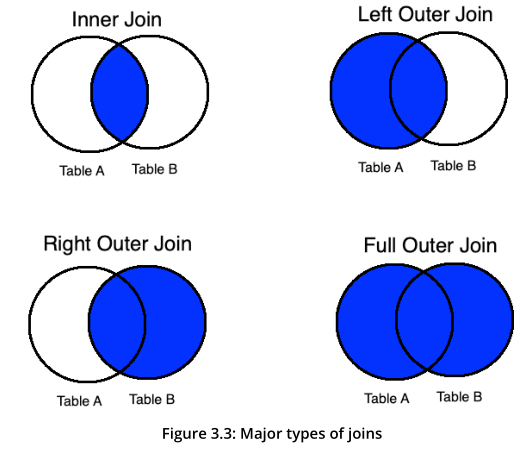

In [33]:
from IPython.display import Image
Image('images/juncoes.PNG')

#### INNER JOIN (JUNÇÃO INTERNA)
A junção interna conecta linhas em tabelas diferentes com base em uma condição conhecida como **predicado de junção**. Em muitos casos, o predicado de junção é uma condição lógica de igualdade. Cada linha da primeira tabela é comparada com todas as outras linhas da segunda tabela. Para combinações de linhas que atendem ao predicado de junção interna, essa linha é retornada na consulta. Caso contrário, a combinação de linhas é descartada. As junções internas geralmente são escritas da seguinte forma:

`SELECT {columns}`

`FROM {table1}`

`INNER JOIN {table2} ON {table1}.{common_key_1}={table2}.{common_key_2}`

Aqui, **{columns}** são as colunas que você deseja obter da tabela unida, **{table1}** é a primeira tabela, **{table2}** é a segunda tabela, **{common_key_1}** é a coluna em **{table1}** na qual você deseja unir e **{common_key_2}** é a coluna em **{table2}** para unir.

Agora, vamos voltar às duas tabelas que discutimos – concessionárias e vendedores. Como mencionado anteriormente, seria bom se pudéssemos anexar as informações da tabela de concessionárias à tabela de vendedores para saber em qual estado cada revendedor trabalha. Por enquanto, vamos supor que todos os IDs de vendedores tenham um **dealership_id** válido.
> ##### Observação
> Neste ponto, você não tem as habilidades necessárias para verificar se todas as IDs de concessionária são válidas na tabela de vendedores e, portanto, assumimos isso. No entanto, em cenários do mundo real, será importante validar essas coisas por conta própria. De um modo geral, existem muito poucos conjuntos de dados e sistemas que garantem dados limpos.

Podemos unir as duas tabelas usando uma condição de igual no predicado de junção, da seguinte forma:

`SELECT *`

`FROM salespeople`

`INNER JOIN dealerships`

`ON salespeople.dealership_id = dealerships.dealership_id`

`ORDER BY 1;`

In [34]:
sql = """
      SELECT *
      FROM salespeople
      INNER JOIN dealerships
        ON salespeople.dealership_id = dealerships.dealership_id
      ORDER BY 1;
      """
df = pd.read_sql_query(con=connection, sql=sql)
df.head()

,salesperson_id,dealership_id,title,first_name,last_name,suffix,username,gender,hire_date,termination_date,dealership_id,street_address,city,state,postal_code,latitude,longitude,date_opened,date_closed
0,1,17,None,Electra,Elleyne,None,eelleyne0,Female,2017-05-31,NaT,17,2120 Walnut Street,Philadelphia,PA,19092,39.950952,-75.177048,2014-06-01,None
1,2,6,None,Montague,Alcoran,None,malcoran1,Male,2018-12-31,NaT,6,7315 California Avenue,Seattle,WA,98136,47.537959,-122.387290,2014-06-01,None
2,3,17,None,Ethyl,Sloss,IV,esloss2,Female,2016-08-10,NaT,17,2120 Walnut Street,Philadelphia,PA,19092,39.950952,-75.177048,2014-06-01,None
3,4,10,None,Nester,Dugood,None,ndugood3,Male,2017-06-03,NaT,10,7425 Wilson Avenue,Chicago,IL,60706,41.963474,-87.813599,2014-06-01,None
4,5,17,None,Cornall,Swanger,None,cswanger4,Male,2018-05-17,NaT,17,2120 Walnut Street,Philadelphia,PA,19092,39.950952,-75.177048,2014-06-01,None


Como você pode ver na saída anterior, a tabela é o resultado da junção da tabela *salespeople* à tabela de *dealerships* (observe também que a primeira tabela listada na consulta, *salespeople*, está no lado esquerdo do resultado, enquanto a tabela A tabela de *dealerships* está do lado direito. Isso é importante para entender na próxima seção). Mais especificamente, o *dealership_id* na tabela *salespeople* corresponde ao *dealership_id*, na tabela de *dealerships*. Isso mostra como o predicado de junção é atendido. Ao executar essa consulta de junção, criamos efetivamente um novo "super conjunto de dados" que consiste nas duas tabelas mescladas em que as duas colunas *dealership_id* são iguais.

Agora podemos consultar esse "superconjunto de dados" da mesma forma que consultaríamos uma tabela grande usando as cláusulas e palavras-chave. Por exemplo, voltando ao nosso problema de várias consultas para determinar qual consulta de vendas funciona na Califórnia, agora podemos resolvê-lo com uma consulta fácil:

In [35]:
sql = """
      SELECT *
      FROM salespeople
      INNER JOIN dealerships
        ON salespeople.dealership_id = dealerships.dealership_id
      WHERE dealerships.state = 'CA'
      ORDER BY 1;
      """
df = pd.read_sql_query(con=connection, sql=sql)
df.head()

,salesperson_id,dealership_id,title,first_name,last_name,suffix,username,gender,hire_date,termination_date,dealership_id,street_address,city,state,postal_code,latitude,longitude,date_opened,date_closed
0,23,2,None,Beauregard,Peschke,None,bpeschkem,Male,2018-09-12,None,2,808 South Hobart Boulevard,Los Angeles,CA,90005,34.057754,-118.305423,2014-06-01,None
1,51,5,None,Lanette,Gerriessen,None,lgerriessen1e,Female,2018-06-24,None,5,2210 Bunker Hill Drive,San Mateo,CA,94402,37.524487,-122.343609,2014-06-01,None
2,57,5,None,Spense,Pithcock,None,spithcock1k,Male,2017-12-15,None,5,2210 Bunker Hill Drive,San Mateo,CA,94402,37.524487,-122.343609,2014-06-01,None
3,61,5,None,Ludvig,Baynam,None,lbaynam1o,Male,2016-08-25,None,5,2210 Bunker Hill Drive,San Mateo,CA,94402,37.524487,-122.343609,2014-06-01,None
4,62,2,None,Carroll,Pudan,None,cpudan1p,Female,2016-05-17,None,2,808 South Hobart Boulevard,Los Angeles,CA,90005,34.057754,-118.305423,2014-06-01,None


Leitores atentos observarão que a saída na Figura 3.2 e na Figura 3.5 são quase idênticas, com a exceção de que a tabela da Figura 3.5 também tem os dados das concessionárias anexados. Se quisermos isolar apenas a parte da tabela salespeople, podemos selecionar as colunas salespeople usando a seguinte sintaxe em estrela:

In [36]:
sql = """
      SELECT salespeople.*
      FROM salespeople
      INNER JOIN dealerships
        ON salespeople.dealership_id = dealerships.dealership_id
      WHERE dealerships.state = 'CA'
      ORDER BY 1;
      """
df = pd.read_sql_query(con=connection, sql=sql)
df.head()

,salesperson_id,dealership_id,title,first_name,last_name,suffix,username,gender,hire_date,termination_date
0,23,2,None,Beauregard,Peschke,None,bpeschkem,Male,2018-09-12,None
1,51,5,None,Lanette,Gerriessen,None,lgerriessen1e,Female,2018-06-24,None
2,57,5,None,Spense,Pithcock,None,spithcock1k,Male,2017-12-15,None
3,61,5,None,Ludvig,Baynam,None,lbaynam1o,Male,2016-08-25,None
4,62,2,None,Carroll,Pudan,None,cpudan1p,Female,2016-05-17,None


Há um outro atalho que pode ajudar ao escrever instruções com várias cláusulas de junção: você pode criar um *alias* para os nomes das tabelas para não precisar digitar o nome inteiro da tabela todas as vezes. Simplesmente escreva o nome do *alias* após a primeira menção da tabela após a cláusula join, e você poderá economizar uma quantidade razoável de digitação. Por exemplo, para a última consulta anterior, se quisermos *alias* *salespeopl* e com **s** e *dealerships* com **d**, você pode escrever a seguinte declaração:

In [37]:
sql = """
      SELECT s.*
      FROM salespeople s
      INNER JOIN dealerships d
        ON s.dealership_id = d.dealership_id
      WHERE d.state = 'CA'
      ORDER BY 1;
      """
df = pd.read_sql_query(con=connection, sql=sql)
df.head()

,salesperson_id,dealership_id,title,first_name,last_name,suffix,username,gender,hire_date,termination_date
0,23,2,None,Beauregard,Peschke,None,bpeschkem,Male,2018-09-12,None
1,51,5,None,Lanette,Gerriessen,None,lgerriessen1e,Female,2018-06-24,None
2,57,5,None,Spense,Pithcock,None,spithcock1k,Male,2017-12-15,None
3,61,5,None,Ludvig,Baynam,None,lbaynam1o,Male,2016-08-25,None
4,62,2,None,Carroll,Pudan,None,cpudan1p,Female,2016-05-17,None


Como alternativa, você também pode colocar a palavra-chave **AS** entre o nome da tabela e o *alias* para tornar o *alias* mais explícito:

In [38]:
sql = """
      SELECT s.*
      FROM salespeople AS s
      INNER JOIN dealerships AS d
        ON s.dealership_id = d.dealership_id
      WHERE d.state = 'CA'
      ORDER BY 1;
      """
df = pd.read_sql_query(con=connection, sql=sql)
df.head()

,salesperson_id,dealership_id,title,first_name,last_name,suffix,username,gender,hire_date,termination_date
0,23,2,None,Beauregard,Peschke,None,bpeschkem,Male,2018-09-12,None
1,51,5,None,Lanette,Gerriessen,None,lgerriessen1e,Female,2018-06-24,None
2,57,5,None,Spense,Pithcock,None,spithcock1k,Male,2017-12-15,None
3,61,5,None,Ludvig,Baynam,None,lbaynam1o,Male,2016-08-25,None
4,62,2,None,Carroll,Pudan,None,cpudan1p,Female,2016-05-17,None


Agora que esclarecemos o básico das junções internas, discutiremos as junções externas.
#### OUTER JOIN (JUNÇÃO EXTERNA)
Conforme discutido, as junções internas retornarão apenas linhas das duas tabelas e somente se o predicado de junção for atendido para ambas as linhas. Caso contrário, nenhuma linha de qualquer tabela será retornada. Às vezes, no entanto, queremos retornar todas as linhas de uma das tabelas, independentemente de o predicado de junção ser atendido. Nesse caso, o predicado de junção não é atendido; a linha da segunda tabela será retornada como **NULL**. Essas junções, nas quais pelo menos uma tabela será representada em cada linha após a operação de junção, são conhecidas como **junções externas**.

As junções externas podem ser classificadas em três categorias: left outer join (junções externas esquerdas), right outer joins (junções externas direitas) e full outer joins (junções externas completas).

As **left outer joins** são onde a tabela esquerda (ou seja, a tabela mencionada primeiro em uma cláusula de junção) terá todas as linhas retornadas. Se uma linha da outra tabela não for encontrada, uma linha de **NULL** será retornada. As junções externas à esquerda são executadas usando as palavras-chave **LEFT OUTER JOIN** seguidas por um predicado de junção. Isso também pode ser escrito como **LEFT JOIN**. Para mostrar como as associações externas à esquerda funcionam, vamos examinar duas tabelas: as tabelas de clientes e a tabela de emails. Por enquanto, suponha que nem todos os clientes receberam um e-mail e queremos enviar a todos os clientes que não receberam um e-mail. Podemos usar associações externas para fazer isso acontecer. Vamos fazer uma junção externa esquerda entre a tabela de clientes à esquerda e a tabela de **emails** à direita. Para ajudar a gerenciar a saída, limitaremos apenas as primeiras 1.000 linhas. O seguinte trecho de código é utilizado:

In [39]:
sql = """
      SELECT *
      FROM customers c
      LEFT OUTER JOIN emails e 
        ON c.customer_id = e.customer_id
      ORDER BY c.customer_id
      LIMIT 1000;
      """
df = pd.read_sql_query(con=connection, sql=sql)
df.head()

,customer_id,title,first_name,last_name,suffix,email,gender,ip_address,phone,street_address,...,date_added,email_id,customer_id,email_subject,opened,clicked,bounced,sent_date,opened_date,clicked_date
0,1,None,Arlena,Riveles,None,ariveles0@stumbleupon.com,F,98.36.172.246,None,None,...,2017-04-23,282584.0,1.0,Black Friday. Green Cars.,t,f,f,2017-11-24 15:00:00,2017-11-26 01:12:32,NaT
1,1,None,Arlena,Riveles,None,ariveles0@stumbleupon.com,F,98.36.172.246,None,None,...,2017-04-23,323983.0,1.0,Save the Planet with some Holiday Savings.,f,f,f,2018-11-23 15:00:00,NaT,NaT
2,1,None,Arlena,Riveles,None,ariveles0@stumbleupon.com,F,98.36.172.246,None,None,...,2017-04-23,370722.0,1.0,"A New Year, And Some New EVs",f,f,f,2019-01-07 15:00:00,NaT,NaT
3,2,Dr,Ode,Stovin,None,ostovin1@npr.org,M,16.97.59.186,314-534-4361,2573 Fordem Parkway,...,2014-10-02,323984.0,2.0,Save the Planet with some Holiday Savings.,f,f,f,2018-11-23 15:00:00,NaT,NaT
4,2,Dr,Ode,Stovin,None,ostovin1@npr.org,M,16.97.59.186,314-534-4361,2573 Fordem Parkway,...,2014-10-02,174737.0,2.0,Like a Bat out of Heaven,f,f,f,2016-09-21 15:00:00,NaT,NaT


Ao observar a saída da consulta, você verá que as entradas da tabela de clientes estão presentes. No entanto, para algumas das linhas, como a linha 27 do cliente que pode ser vista na Figura 3.7, as colunas pertencentes à tabela de emails estão completamente cheias de nulos. Esse arranjo explica como a junção externa é diferente da junção interna. Se a junção interna fosse usada, a coluna *customer_id* não ficaria em branco. Essa consulta, no entanto, ainda é útil porque agora podemos usá-la para encontrar pessoas que nunca receberam um email. Como os clientes que nunca receberam um e-mail têm uma coluna *customer_id* nula na tabela de e-mails, podemos encontrar todos esses clientes verificando a coluna *customer_id* na tabela de e-mails da seguinte forma:

In [40]:
sql = """
      SELECT *
      FROM customers c
      LEFT OUTER JOIN emails e 
        ON c.customer_id = e.customer_id
      WHERE e.customer_id IS NULL
      ORDER BY c.customer_id
      LIMIT 1000;
      """
df = pd.read_sql_query(con=connection, sql=sql)
df.head()

,customer_id,title,first_name,last_name,suffix,email,gender,ip_address,phone,street_address,...,date_added,email_id,customer_id,email_subject,opened,clicked,bounced,sent_date,opened_date,clicked_date
0,27,None,Anson,Fellibrand,None,afellibrandq@topsy.com,M,64.80.85.50,203-107-9111,65 Shelley Road,...,2019-04-07,None,None,None,None,None,None,None,None,None
1,32,None,Hamnet,Purselowe,None,hpurselowev@oaic.gov.au,M,225.215.209.222,239-462-4672,5 Johnson Way,...,2019-02-07,None,None,None,None,None,None,None,None,None
2,70,None,Caty,Woolveridge,None,cwoolveridge1x@netscape.com,F,104.21.118.34,757-238-9531,None,...,2019-04-09,None,None,None,None,None,None,None,None,None
3,77,None,Donal,Lattey,None,dlattey24@examiner.com,M,5.31.114.103,304-575-4910,48889 Laurel Pass,...,2019-05-25,None,None,None,None,None,None,None,None,None
4,112,None,Harcourt,Cripps,None,hcripps33@goodreads.com,M,219.20.188.201,951-922-6694,9 Hoard Place,...,2019-02-21,None,None,None,None,None,None,None,None,None


Como você pode ver, todas as entradas estão em branco na coluna **customer_id**, indicando que eles não receberam nenhum e-mail. Poderíamos simplesmente pegar os e-mails desta junção para obter todos os clientes que não receberam um e-mail.

Uma **junção externa direita** é muito semelhante a uma junção esquerda, exceto que a tabela à "direita" (a segunda tabela listada) agora terá todas as linhas exibidas e a tabela "esquerda" terá **NULLs** se a condição de junção não for atendida . Para ilustrar, vamos "inverter" a última consulta juntando a tabela de emails à direita da tabela de clientes com a seguinte consulta:

In [41]:
sql = """
      SELECT *
      FROM emails e
      RIGHT OUTER JOIN customers c ON e.customer_id=c.customer_id
      ORDER BY c.customer_id
      LIMIT 1000;
      """
df = pd.read_sql_query(con=connection, sql=sql)
df.head()

,email_id,customer_id,email_subject,opened,clicked,bounced,sent_date,opened_date,clicked_date,customer_id,...,gender,ip_address,phone,street_address,city,state,postal_code,latitude,longitude,date_added
0,282584.0,1.0,Black Friday. Green Cars.,t,f,f,2017-11-24 15:00:00,2017-11-26 01:12:32,NaT,1,...,F,98.36.172.246,None,None,None,None,None,NaN,NaN,2017-04-23
1,370722.0,1.0,"A New Year, And Some New EVs",f,f,f,2019-01-07 15:00:00,NaT,NaT,1,...,F,98.36.172.246,None,None,None,None,None,NaN,NaN,2017-04-23
2,323983.0,1.0,Save the Planet with some Holiday Savings.,f,f,f,2018-11-23 15:00:00,NaT,NaT,1,...,F,98.36.172.246,None,None,None,None,None,NaN,NaN,2017-04-23
3,370723.0,2.0,"A New Year, And Some New EVs",f,f,f,2019-01-07 15:00:00,NaT,NaT,2,...,M,16.97.59.186,314-534-4361,2573 Fordem Parkway,Saint Louis,MO,63116,38.5814,-90.2625,2014-10-02
4,323984.0,2.0,Save the Planet with some Holiday Savings.,f,f,f,2018-11-23 15:00:00,NaT,NaT,2,...,M,16.97.59.186,314-534-4361,2573 Fordem Parkway,Saint Louis,MO,63116,38.5814,-90.2625,2014-10-02


Observe que essa saída é semelhante ao que foi produzido anteriormente, exceto que os dados da tabela de emails estão agora no lado esquerdo e os dados da tabela de clientes estão no lado direito. Mais uma vez, **customer_id** 27 tem **NULL** para o email. Isso mostra a simetria entre uma junção direita e uma junção esquerda.

Finalmente, há a junção externa completa. A junção externa completa retornará todas as linhas das tabelas esquerda e direita, independentemente de o predicado da junção corresponder. Para linhas em que o predicado de junção é atendido, as duas linhas são combinadas em um grupo. Para linhas em que não são atendidas, a linha tem **NULL** preenchido. A junção externa completa é chamada usando a cláusula **FULL OUTER JOIN**, seguida por um predicado de junção. Aqui está a sintaxe desta junção:

In [42]:
sql = """
      SELECT *
      FROM emails e
      FULL OUTER JOIN customers c
        ON e.customer_id=c.customer_id;
      """
df = pd.read_sql_query(con=connection, sql=sql)
df.head()

,email_id,customer_id,email_subject,opened,clicked,bounced,sent_date,opened_date,clicked_date,customer_id,...,gender,ip_address,phone,street_address,city,state,postal_code,latitude,longitude,date_added
0,1.0,18.0,Introducing A Limited Edition,f,f,f,2011-01-03 15:00:00,NaT,NaT,18,...,F,32.6.245.101,None,907 Milwaukee Park,Bloomington,IN,47405,39.1682,-86.5186,2010-03-16
1,2.0,30.0,Introducing A Limited Edition,f,f,f,2011-01-03 15:00:00,NaT,NaT,30,...,F,116.13.53.143,512-942-0905,None,None,None,None,NaN,NaN,2010-08-05
2,4.0,52.0,Introducing A Limited Edition,f,f,f,2011-01-03 15:00:00,NaT,NaT,52,...,M,26.56.68.189,212-959-9172,6 Onsgard Terrace,New York City,NY,10131,40.7808,-73.9772,2010-07-06
3,9.0,103.0,Introducing A Limited Edition,f,f,f,2011-01-03 15:00:00,NaT,NaT,103,...,F,40.27.235.11,941-420-8612,0357 Oriole Plaza,Sarasota,FL,34233,27.2866,-82.4770,2010-07-13
4,14.0,137.0,Introducing A Limited Edition,f,f,f,2011-01-03 15:00:00,NaT,NaT,137,...,F,52.120.127.193,419-647-6042,08962 Sunbrook Place,Toledo,OH,43605,41.6525,-83.5085,2010-11-28


#### CROSS JOIN
O tipo final de junção que discutiremos neste módulo é a CROSS JOIN (junção cruzada). A junção cruzada é matematicamente o que também é chamado de produto cartesiano - ela retorna todas as combinações possíveis de linhas da tabela "esquerda" e da tabela "direita". Ele pode ser invocado usando uma cláusula **CROSS JOIN**, seguida pelo nome da outra tabela. Por exemplo, vamos pegar o exemplo da tabela de produtos. Digamos que queríamos conhecer todas as combinações possíveis de dois produtos que você poderia criar a partir de um determinado conjunto de produtos (como o encontrado na tabela de produtos) para criar um sorteio de dois meses para fins de marketing. Podemos usar uma junção cruzada para obter a resposta para a pergunta usando a seguinte consulta:

In [43]:
sql = """
      SELECT p1.product_id, p1.model, p2.product_id, p2.model
      FROM products p1 CROSS JOIN products p2;
      """
df = pd.read_sql_query(con=connection, sql=sql)
df.head()

,product_id,model,product_id,model
0,1,Lemon,1,Lemon
1,1,Lemon,2,Lemon Limited Edition
2,1,Lemon,3,Lemon
3,1,Lemon,5,Blade
4,1,Lemon,7,Bat


Você observará que, neste caso específico, juntamos uma tabela a ela mesma. Esta é uma operação perfeitamente válida e também é conhecida como autojunção. O resultado da consulta possui 144 linhas, o que equivale a multiplicar os 12 produtos pelo mesmo número (12 * 12). Também podemos ver que não há necessidade de um predicado de junção; na verdade, uma junção cruzada pode ser considerada apenas como uma junção externa sem condições para a junção.

Em geral, as junções cruzadas não são usadas na prática e também podem ser muito perigosas se você não for cuidadoso. A junção cruzada de duas grandes tabelas pode levar à originação de centenas de bilhões de linhas, o que pode travar e travar um banco de dados. Tome cuidado ao usá-los.
> ##### Observação
> Para saber mais sobre junções, confira a documentação do PostgreSQL aqui: https://www.postgresql.org/docs/9.1/queries-table-expressions.html.

Até este ponto, abordamos o básico do uso de junções para reunir tabelas. Agora falaremos sobre métodos para unir consultas em um conjunto de dados.

### Exercício 10: Usando Junções para Analisar a Concessionária de Vendas
O chefe de vendas da sua empresa gostaria de uma lista de todos os clientes que compraram um carro. Precisamos criar uma consulta que retornará todos os IDs de clientes, nomes, sobrenomes e números de telefone válidos de clientes que compraram um carro.

In [44]:
sql = """
      SELECT c.customer_id, c.first_name, c.last_name, c.phone
      FROM sales AS s
      INNER JOIN customers c
         ON c.customer_id = s.customer_id
      INNER JOIN products p
         ON s.product_id = p.product_id
      WHERE p.product_type = 'automobile' AND c.phone IS NOT NULL;
      """
df = pd.read_sql_query(con=connection, sql=sql)
df.head()

,customer_id,first_name,last_name,phone
0,35824,Wyatan,Dickie,405-786-0858
1,13206,Stace,Tuison,810-769-8255
2,2958,Kirstyn,Draysay,208-534-6858
3,32636,Kile,Fishlee,937-207-1484
4,26730,Raina,Titterell,304-871-4445


### Subqueries (Subconsultas)
A partir de agora, estamos extraindo dados de tabelas. No entanto, você deve ter observado que todas as consultas **SELECT** produzem tabelas como saída. Sabendo disso, você pode se perguntar se existe alguma maneira de usar as tabelas produzidas por consultas **SELECT** em vez de referenciar uma tabela existente em seu banco de dados. A resposta é sim. Você pode simplesmente pegar uma consulta, inserí-la entre parênteses e dar a ela um *alias*. Por exemplo, se quiséssemos encontrar todos os vendedores que trabalham na Califórnia, poderíamos ter escrito a consulta usando a seguinte alternativa:

In [45]:
sql = """
      SELECT *
      FROM salespeople
      INNER JOIN (
          SELECT * 
          FROM dealerships
          WHERE dealerships.state = 'CA'
          ) d
        ON d.dealership_id = salespeople.dealership_id
      ORDER BY 1
      """
df = pd.read_sql_query(con=connection, sql=sql)
df.head()

,salesperson_id,dealership_id,title,first_name,last_name,suffix,username,gender,hire_date,termination_date,dealership_id,street_address,city,state,postal_code,latitude,longitude,date_opened,date_closed
0,23,2,None,Beauregard,Peschke,None,bpeschkem,Male,2018-09-12,None,2,808 South Hobart Boulevard,Los Angeles,CA,90005,34.057754,-118.305423,2014-06-01,None
1,51,5,None,Lanette,Gerriessen,None,lgerriessen1e,Female,2018-06-24,None,5,2210 Bunker Hill Drive,San Mateo,CA,94402,37.524487,-122.343609,2014-06-01,None
2,57,5,None,Spense,Pithcock,None,spithcock1k,Male,2017-12-15,None,5,2210 Bunker Hill Drive,San Mateo,CA,94402,37.524487,-122.343609,2014-06-01,None
3,61,5,None,Ludvig,Baynam,None,lbaynam1o,Male,2016-08-25,None,5,2210 Bunker Hill Drive,San Mateo,CA,94402,37.524487,-122.343609,2014-06-01,None
4,62,2,None,Carroll,Pudan,None,cpudan1p,Female,2016-05-17,None,2,808 South Hobart Boulevard,Los Angeles,CA,90005,34.057754,-118.305423,2014-06-01,None


Aqui, em vez de unir as duas tabelas e filtrar as linhas com o estado igual a **'CA'**, primeiro encontramos as concessionárias onde o estado é igual a **'CA'** e, em seguida, juntamos internamente as linhas nessa consulta aos vendedores.

Se uma consulta tiver apenas uma coluna, você poderá usar uma subconsulta com a palavra-chave **IN** em uma cláusula **WHERE**. Por exemplo, outra maneira de extrair os detalhes da tabela de vendedores usando o ID da concessionária para o estado da Califórnia seria a seguinte:

In [46]:
sql = """
      SELECT *
      FROM salespeople
      WHERE dealership_id IN (
            SELECT dealership_id
            FROM dealerships
            WHERE dealerships.state = 'CA'
            )
      ORDER BY 1
      """
df = pd.read_sql_query(con=connection, sql=sql)
df.head()

,salesperson_id,dealership_id,title,first_name,last_name,suffix,username,gender,hire_date,termination_date
0,23,2,None,Beauregard,Peschke,None,bpeschkem,Male,2018-09-12,None
1,51,5,None,Lanette,Gerriessen,None,lgerriessen1e,Female,2018-06-24,None
2,57,5,None,Spense,Pithcock,None,spithcock1k,Male,2017-12-15,None
3,61,5,None,Ludvig,Baynam,None,lbaynam1o,Male,2016-08-25,None
4,62,2,None,Carroll,Pudan,None,cpudan1p,Female,2016-05-17,None


Como todos esses exemplos mostram, é muito fácil escrever a mesma consulta usando várias técnicas. Na próxima seção, falaremos sobre **Unions**.

#### Unions
Até agora, falamos sobre como juntar dados horizontalmente. Ou seja, com junções, novas colunas são efetivamente adicionadas horizontalmente. No entanto, podemos estar interessados em reunir várias consultas verticalmente; isto é, mantendo o mesmo número de colunas, mas adicionando várias linhas. Um exemplo pode ajudar a esclarecer isso. Digamos que você queira visualizar os endereços de concessionárias e clientes usando o Google Maps. Para fazer isso, você precisaria dos endereços dos clientes e das concessionárias. Você pode criar uma consulta com todos os endereços dos clientes da seguinte maneira:

In [47]:
sql = """
      SELECT street_address, city, state, postal_code
      FROM customers
      WHERE street_address IS NOT NULL;
      """
df = pd.read_sql_query(con=connection, sql=sql)
df.head()

,street_address,city,state,postal_code
0,2573 Fordem Parkway,Saint Louis,MO,63116
1,5651 Kennedy Park,Pensacola,FL,32590
2,224 Village Circle,Nashville,TN,37215
3,38 Lindbergh Way,Miami,FL,33124
4,6537 Delladonna Drive,Miami,FL,33158


Você também pode recuperar endereços de concessionárias com a seguinte consulta:

In [48]:
sql = """
      SELECT street_address, city, state, postal_code
      FROM dealerships
      WHERE street_address IS NOT NULL;
      """
df = pd.read_sql_query(con=connection, sql=sql)
df.head()

,street_address,city,state,postal_code
0,52 Hillside Terrace,Millburn,NJ,07039
1,808 South Hobart Boulevard,Los Angeles,CA,90005
2,16801 Lee Road,Houston,TX,77032
3,2437 NW 28th Street,Miami,FL,33242
4,2210 Bunker Hill Drive,San Mateo,CA,94402


No entanto, seria bom se pudéssemos reunir as duas consultas em uma lista com uma consulta. É aqui que a palavra-chave **UNION** entra em jogo. Usando as duas consultas anteriores, poderíamos criar a consulta:

In [49]:
sql = """
      (
        SELECT street_address, city, state, postal_code
        FROM customers
        WHERE street_address IS NOT NULL
        )
      UNION
      
      (
        SELECT street_address, city, state, postal_code
        FROM dealerships
        WHERE street_address IS NOT NULL
        )
      ORDER BY 1;
      """
df = pd.read_sql_query(con=connection, sql=sql)
df.head()

,street_address,city,state,postal_code
0,0 1st Avenue,Madison,WI,53710
1,0 1st Plaza,Scranton,PA,18514
2,0 2nd Parkway,Maple Plain,MN,55572
3,0 2nd Pass,Richmond,VA,23213
4,0 2nd Point,Charleston,WV,25389


Existem algumas ressalvas ao usar UNION. Primeiro, UNION requer que as subconsultas tenham as mesmas colunas de nome e os mesmos tipos de dados para a coluna. Caso contrário, a consulta não será executada. Segundo, UNION tecnicamente pode não retornar todas as linhas de suas subconsultas. **UNION**, por padrão, remove todas as linhas duplicadas na saída. Se você deseja manter as linhas duplicadas, é preferível usar a palavra-chave **UNION ALL**.

### Exercício 11: Gerando uma Lista de Convidados de Grupos de Clientes Elite usando UNION
Neste exercício, vamos montar duas consultas usando uniões. Para ajudar a aumentar a conscientização de marketing para o novo Model Chi, a equipe de marketing gostaria de dar uma festa para alguns dos clientes mais ricos da ZoomZoom em Los Angeles, CA. Para ajudar a facilitar a festa, eles gostariam que você fizesse uma lista de convidados com clientes ZoomZoom que moram em Los Angeles, CA, bem como vendedores que trabalham na concessionária ZoomZoom em Los Angeles, CA. A lista de convidados deve incluir o primeiro nome, o sobrenome e se o convidado é um cliente ou um funcionário.

In [50]:
sql = """
      (
        SELECT first_name, last_name, 'Customer' as guest_type
        FROM customers
        WHERE city='Los Angeles'
        AND state='CA'
        )
      
      UNION
      
      (
        SELECT first_name, last_name, 'Employee' as guest_type
        FROM salespeople s
        INNER JOIN dealerships d ON d.dealership_id=s.dealership_id
        WHERE d.city='Los Angeles'
        AND d.state='CA'
        )
      """
df = pd.read_sql_query(con=connection, sql=sql)
df.head()

,first_name,last_name,guest_type
0,Euell,MacWhirter,Customer
1,Martainn,Tordoff,Customer
2,Truman,Cutmore,Customer
3,Asher,Drogan,Customer
4,Kelley,Christley,Customer


Podemos ver a lista de convidados de clientes e funcionários de Los Angeles, CA após executar a consulta **UNION**.

No exercício, usamos a palavra-chave **UNION** para combinar linhas de diferentes consultas sem esforço.

### Expressões de Tabela Comuns
Expressões de tabela comuns são, em certo sentido, apenas uma versão diferente de subconsultas. As expressões de tabela comuns estabelecem tabelas temporárias usando a cláusula **WITH**. Para entender melhor esta cláusula, vamos dar uma olhada na seguinte consulta:

In [51]:
sql = """
      SELECT *
      FROM salespeople
      INNER JOIN (
          SELECT * FROM dealerships
          WHERE dealerships.state = 'CA'
          ) d
        ON d.dealership_id = salespeople.dealership_id
      ORDER BY 1
      """
df = pd.read_sql_query(con=connection, sql=sql)
df.head()

,salesperson_id,dealership_id,title,first_name,last_name,suffix,username,gender,hire_date,termination_date,dealership_id,street_address,city,state,postal_code,latitude,longitude,date_opened,date_closed
0,23,2,None,Beauregard,Peschke,None,bpeschkem,Male,2018-09-12,None,2,808 South Hobart Boulevard,Los Angeles,CA,90005,34.057754,-118.305423,2014-06-01,None
1,51,5,None,Lanette,Gerriessen,None,lgerriessen1e,Female,2018-06-24,None,5,2210 Bunker Hill Drive,San Mateo,CA,94402,37.524487,-122.343609,2014-06-01,None
2,57,5,None,Spense,Pithcock,None,spithcock1k,Male,2017-12-15,None,5,2210 Bunker Hill Drive,San Mateo,CA,94402,37.524487,-122.343609,2014-06-01,None
3,61,5,None,Ludvig,Baynam,None,lbaynam1o,Male,2016-08-25,None,5,2210 Bunker Hill Drive,San Mateo,CA,94402,37.524487,-122.343609,2014-06-01,None
4,62,2,None,Carroll,Pudan,None,cpudan1p,Female,2016-05-17,None,2,808 South Hobart Boulevard,Los Angeles,CA,90005,34.057754,-118.305423,2014-06-01,None


Isso pode ser escrito usando expressões de tabela comuns da seguinte forma:

In [52]:
sql = """
      WITH d as (
        SELECT * FROM dealerships
        WHERE dealerships.state = 'CA'
        )
      SELECT *
      FROM salespeople
      INNER JOIN d ON d.dealership_id = salespeople.dealership_id
      ORDER BY 1;
      """
df = pd.read_sql_query(con=connection, sql=sql)
df.head()

,salesperson_id,dealership_id,title,first_name,last_name,suffix,username,gender,hire_date,termination_date,dealership_id,street_address,city,state,postal_code,latitude,longitude,date_opened,date_closed
0,23,2,None,Beauregard,Peschke,None,bpeschkem,Male,2018-09-12,None,2,808 South Hobart Boulevard,Los Angeles,CA,90005,34.057754,-118.305423,2014-06-01,None
1,51,5,None,Lanette,Gerriessen,None,lgerriessen1e,Female,2018-06-24,None,5,2210 Bunker Hill Drive,San Mateo,CA,94402,37.524487,-122.343609,2014-06-01,None
2,57,5,None,Spense,Pithcock,None,spithcock1k,Male,2017-12-15,None,5,2210 Bunker Hill Drive,San Mateo,CA,94402,37.524487,-122.343609,2014-06-01,None
3,61,5,None,Ludvig,Baynam,None,lbaynam1o,Male,2016-08-25,None,5,2210 Bunker Hill Drive,San Mateo,CA,94402,37.524487,-122.343609,2014-06-01,None
4,62,2,None,Carroll,Pudan,None,cpudan1p,Female,2016-05-17,None,2,808 South Hobart Boulevard,Los Angeles,CA,90005,34.057754,-118.305423,2014-06-01,None


A única vantagem das expressões de tabela comuns é que elas são recursivas. **Expressões de tabela comuns recursivas** podem fazer referência a si mesmas. Devido a esse recurso, podemos usá-los para resolver problemas que outras consultas não conseguem. No entanto, expressões de tabela comuns recursivas estão além do escopo deste módulo. Agora que conhecemos várias maneiras de unir dados em um banco de dados, veremos como transformar os dados dessas saídas.

## Transformando dados
Muitas vezes, os dados brutos apresentados em uma saída de consulta podem não estar na forma que gostaríamos que estivessem. Podemos querer remover valores, substituir valores ou mapear valores para outros valores. Para realizar essas tarefas, o SQL fornece uma ampla variedade de instruções e funções. Funções são palavras-chave que recebem entradas como uma coluna ou um valor escalar e alteram essas entradas em algum tipo de saída. Discutiremos algumas funções muito úteis para limpar dados nas seções a seguir.
### **CASE WHEN**
**CASE WHEN** é uma função que permite que uma consulta mapeie vários valores em uma coluna para outros valores. O formato geral de uma instrução **CASE WHEN** é:

`CASE WHEN condition1 THEN value1`

`WHEN condition2 THEN value2`

`...`

`WHEN conditionX THEN valueX`

`ELSE else_value END`

Aqui, **condition1** e **condition2**, por meio de **conditionX**, são condições booleanas; **valor1** e **valor2**, por meio de **valorX**, são valores para mapear as condições booleanas; e **else_value** é o valor mapeado se nenhuma das condições booleanas for atendida. Para cada linha, o programa inicia na parte superior da instrução **CASE WHEN** e avalia a primeira condição booleana. O programa então passa por cada condição booleana da primeira. Para a primeira condição desde o início da instrução avaliada como verdadeira, a instrução retornará o valor associado a essa condição. Se nenhuma das instruções for avaliada como verdadeira, o valor associado à instrução **ELSE** será retornado.

Como exemplo, digamos que você queira retornar todas as linhas de clientes da tabela de **customers**. Além disso, você gostaria de adicionar uma coluna que rotule um usuário como um **Elite Customer** se ele residir no código postal **33111** ou como um **Premium Customer** se ele residir no código postal **33124**. Caso contrário, ele marcará o cliente como um cliente padrão. Esta coluna será chamada **customer_type**. Podemos criar essa tabela usando uma instrução **CASE WHEN** da seguinte forma:

In [53]:
sql = """
      SELECT *,
        CASE WHEN postal_code= '33111' THEN 'Elite Customer'
        WHEN postal_code= '33124' THEN 'Premium Customer'
        ELSE 'Standard Customer' END
        AS customer_type
      FROM customers;
      """
df = pd.read_sql_query(con=connection, sql=sql)
df.head()

,customer_id,title,first_name,last_name,suffix,email,gender,ip_address,phone,street_address,city,state,postal_code,latitude,longitude,date_added,customer_type
0,1,None,Arlena,Riveles,None,ariveles0@stumbleupon.com,F,98.36.172.246,None,None,None,None,None,NaN,NaN,2017-04-23,Standard Customer
1,2,Dr,Ode,Stovin,None,ostovin1@npr.org,M,16.97.59.186,314-534-4361,2573 Fordem Parkway,Saint Louis,MO,63116,38.5814,-90.2625,2014-10-02,Standard Customer
2,3,None,Braden,Jordan,None,bjordan2@geocities.com,M,192.86.248.59,None,5651 Kennedy Park,Pensacola,FL,32590,30.6143,-87.2758,2018-10-27,Standard Customer
3,4,None,Jessika,Nussen,None,jnussen3@salon.com,F,159.165.138.166,615-824-2506,224 Village Circle,Nashville,TN,37215,36.0986,-86.8219,2017-09-03,Standard Customer
4,5,None,Lonnie,Rembaud,None,lrembaud4@discovery.com,F,18.131.58.65,786-499-3431,38 Lindbergh Way,Miami,FL,33124,25.5584,-80.4582,2014-03-06,Premium Customer


Como você pode ver na tabela anterior, há uma coluna chamada **customer_type** indicando o tipo de cliente que um usuário é. A instrução **CASE WHEN** mapeou efetivamente um código postal para uma string descrevendo o tipo de cliente. Usando uma instrução **CASE WHEN**, você pode mapear valores da maneira que desejar.

### Exercício 12: Usando a Função CASE WHEN para Obter Listas Regionais
O objetivo é criar uma consulta que mapeie vários valores em uma coluna para outros valores. O chefe de vendas tem a ideia de tentar criar equipes de vendas regionais especializadas que poderão vender scooters para clientes em regiões específicas, em oposição a equipes de vendas genéricas. Para tornar sua ideia realidade, ele gostaria de uma lista de todos os clientes mapeados para as regiões. Para clientes dos estados de MA, NH, VT, ME, CT ou RI, ele gostaria que fossem rotulados como **New England**. Para clientes dos estados de GA, FL, MS, AL, LA, KY, VA, NC, SC, TN, VI, WV ou AR, ele gostaria que os clientes fossem rotulados como Sudeste. Clientes de qualquer outro estado devem ser rotulados como **Other**:

In [54]:
sql = """
      SELECT c.customer_id, c.first_name, c.last_name,
        CASE WHEN state IN ('MA', 'NH', 'VT', 'ME', 'CT', 'RI') THEN 'New England'
        WHEN state IN ('GA', 'FL', 'MS', 'AL', 'LA', 'KY', 'VA', 'NC', 'SC', 'TN', 'VI', 'WV', 'AR') THEN 'Southeast'
        ELSE 'Other' END
        AS region 
      FROM customers c;
      """
df = pd.read_sql_query(con=connection, sql=sql)
df.head()

,customer_id,first_name,last_name,region
0,1,Arlena,Riveles,Other
1,2,Ode,Stovin,Other
2,3,Braden,Jordan,Southeast
3,4,Jessika,Nussen,Southeast
4,5,Lonnie,Rembaud,Southeast


#### COALESCE
Outra técnica útil é substituir valores **NULL** por um valor padrão. Isso pode ser feito facilmente por meio da função COALESCE. COALESCE permite listar qualquer número de colunas e valores escalares e, se o primeiro valor da lista for **NULL**, tentará preenchê-lo com o segundo valor. A função **COALESCE** continuará descendo a lista de valores até atingir um valor diferente de **NULL**. Se todos os valores na função **COALESCE** forem **NULL**, a função retornará **NULL**.

Para ilustrar um uso simples da função **COALESCE**, voltemos à tabela de clientes.

Digamos que a equipe de marketing queira uma lista dos nomes, sobrenomes e números de telefone de todos os clientes do sexo masculino. No entanto, para os clientes sem número de telefone, eles gostariam que a tabela escrevesse o valor **'NO PHONE'**. Podemos realizar este pedido com COALESCE:

In [55]:
sql = """
      SELECT first_name, last_name,
            COALESCE(phone, 'NO PHONE') as phone
      FROM customers
      ORDER BY 1;
      """
df = pd.read_sql_query(con=connection, sql=sql)
df.head()

,first_name,last_name,phone
0,Aaren,Whelpdale,607-761-2568
1,Aaren,Norrey,NO PHONE
2,Aaren,Sadat,504-559-3464
3,Aaren,Deeman,NO PHONE
4,Aaren,Lamlin,414-937-4628


Ao lidar com a criação de valores padrão e evitar **NULL**, **COALESCE** sempre será útil.

### NULLIF
**NULLIF** é, em certo sentido, o oposto de **COALESCE**. **NULLIF** é uma função de dois valores e retornará **NULL** se o primeiro valor for igual ao segundo valor.

Como exemplo, imagine que o departamento de marketing criou uma nova mala direta para enviar ao cliente. Uma das peculiaridades dessa nova peça publicitária é que ela não pode aceitar pessoas que tenham títulos com mais de três letras. Em nosso banco de dados, o único título conhecido com mais de três caracteres é **'Honorable'**. Portanto, eles gostariam que você criasse uma lista de discussão que fosse apenas todas as linhas com endereços válidos e apagasse todos os títulos com **NULL** que são escritos como **'Honorable'**. Isso pode ser feito com a seguinte consulta:

In [56]:
sql = """
      SELECT customer_id,
        NULLIF(title, 'Honorable') as title,
        first_name,
        last_name,
        suffix,
        email,
        gender,
        ip_address,
        phone,
        street_address,
        city,
        state,
        postal_code,
        latitude,
        longitude,
        date_added
      FROM customers c
      ORDER BY 1
      """
df = pd.read_sql_query(con=connection, sql=sql)
df.head()

,customer_id,title,first_name,last_name,suffix,email,gender,ip_address,phone,street_address,city,state,postal_code,latitude,longitude,date_added
0,1,None,Arlena,Riveles,None,ariveles0@stumbleupon.com,F,98.36.172.246,None,None,None,None,None,NaN,NaN,2017-04-23
1,2,Dr,Ode,Stovin,None,ostovin1@npr.org,M,16.97.59.186,314-534-4361,2573 Fordem Parkway,Saint Louis,MO,63116,38.5814,-90.2625,2014-10-02
2,3,None,Braden,Jordan,None,bjordan2@geocities.com,M,192.86.248.59,None,5651 Kennedy Park,Pensacola,FL,32590,30.6143,-87.2758,2018-10-27
3,4,None,Jessika,Nussen,None,jnussen3@salon.com,F,159.165.138.166,615-824-2506,224 Village Circle,Nashville,TN,37215,36.0986,-86.8219,2017-09-03
4,5,None,Lonnie,Rembaud,None,lrembaud4@discovery.com,F,18.131.58.65,786-499-3431,38 Lindbergh Way,Miami,FL,33124,25.5584,-80.4582,2014-03-06


Isso apagará todas as menções de 'Honorável' da coluna do título.

#### LEAST/GREATEST
Duas funções úteis para a preparação de dados são as funções **LEAST** e **GREATEST**. Cada função recebe qualquer número de valores e retorna o menor ou o maior dos valores, respectivamente.

Um uso simples dessa variável seria substituir o valor se for muito alto ou baixo. Por exemplo, a equipe de vendas pode querer criar uma lista de vendas em que cada scooter custa US$ 600 ou menos que isso. Podemos criar isso usando a seguinte consulta:

In [57]:
sql = """
      SELECT product_id,
      model,
      year,
      product_type,
      
      LEAST(600.00, base_msrp) as base_msrp,
      production_start_date,
      production_end_date
      FROM products
      WHERE product_type='scooter'
      ORDER BY 1;
      """
df = pd.read_sql_query(con=connection, sql=sql)
df.head()

,product_id,model,year,product_type,base_msrp,production_start_date,production_end_date
0,1,Lemon,2010,scooter,399.99,2010-03-03,2012-06-08
1,2,Lemon Limited Edition,2011,scooter,600.00,2011-01-03,2011-03-30
2,3,Lemon,2013,scooter,499.99,2013-05-01,2018-12-28
3,5,Blade,2014,scooter,600.00,2014-06-23,2015-01-27
4,7,Bat,2016,scooter,599.99,2016-10-10,NaT


### Casting
Outra transformação de dados útil é alterar o tipo de dados de uma coluna em uma consulta. Isso geralmente é feito para usar uma função disponível apenas para um tipo de dados, como texto, ao trabalhar com uma coluna que está em um tipo de dados diferente, como numérico. Para alterar o tipo de dados de uma coluna, basta usar o formato **column::datatype**, onde **column** é o nome da coluna e **datatype** é o tipo de dados para o qual você deseja alterar a coluna. Por exemplo, para alterar o ano na tabela de produtos para uma coluna de texto em uma consulta, use a seguinte consulta:

In [58]:
sql = """
      SELECT product_id,
       model,
       year::TEXT,
       product_type,
       base_msrp,
       production_start_date,
       production_end_date
      FROM products;
      """
df = pd.read_sql_query(con=connection, sql=sql)
df.head()

,product_id,model,year,product_type,base_msrp,production_start_date,production_end_date
0,1,Lemon,2010,scooter,399.99,2010-03-03,2012-06-08
1,2,Lemon Limited Edition,2011,scooter,799.99,2011-01-03,2011-03-30
2,3,Lemon,2013,scooter,499.99,2013-05-01,2018-12-28
3,5,Blade,2014,scooter,699.99,2014-06-23,2015-01-27
4,7,Bat,2016,scooter,599.99,2016-10-10,NaT


Isso converterá a coluna do ano em texto. Agora você pode aplicar funções de texto a esta coluna transformada. Há uma captura final; nem todo tipo de dados pode ser convertido em um tipo de dados específico. Por exemplo, **datetime** não pode ser convertido em tipos float. Seu cliente SQL lançará um erro se você fizer uma conversão estranha inesperada.

### DISTINCT e DISTINCT ON
Muitas vezes, ao examinar um conjunto de dados, você pode estar interessado em determinar os valores exclusivos em uma coluna ou grupo de colunas. Este é o caso de uso principal da palavra-chave **DISTINCT**. Por exemplo, se você quiser saber todos os anos do modelo exclusivo na tabela de produtos, poderá usar a seguinte consulta:

In [59]:
sql = """
      SELECT DISTINCT year
      FROM products
      ORDER BY 1;
      """
df = pd.read_sql_query(con=connection, sql=sql)
df.head()

,year
0,2010
1,2011
2,2013
3,2014
4,2015


Você também pode usá-lo com várias colunas para obter todas as combinações de colunas distintas presentes. Por exemplo, para encontrar todos os anos distintos e quais tipos de produtos foram lançados para esses anos de modelo, você pode simplesmente usar o seguinte:

In [60]:
sql = """
      SELECT DISTINCT year, product_type
      FROM products
      ORDER BY 1, 2;
      """
df = pd.read_sql_query(con=connection, sql=sql)
df.head()

,year,product_type
0,2010,scooter
1,2011,scooter
2,2013,scooter
3,2014,automobile
4,2014,scooter


Uma palavra-chave relacionada a DISTINCT é DISTINCT ON. DISTINCT ON permite que você garanta que apenas uma linha é retornada onde uma ou mais colunas são sempre exclusivas no conjunto. o sintaxe geral de uma consulta DISTINCT ON é:

`SELECT DISTINCT ON (distinct_column)`

`column_1,`

`column_2,`

`...`

`column_n`

`FROM table`

`ORDER BY order_column;`

Aqui, **dictinct_column** é a coluna ou colunas que você deseja que sejam distintas em sua consulta, **column_1** a **column_n** são as colunas que você deseja na consulta e **order_column** permite determinar a primeira linha que será retornada para uma consulta **DISTINCT ON** se várias colunas têm o mesmo valor para **distinct_column**. Para **order_column**, a primeira coluna mencionada deve ser **distinct_column**. Se uma cláusula **ORDER BY** não for especificada, a primeira linha será decidida aleatoriamente. Para esclarecer, digamos que você queira obter uma lista exclusiva de vendedores em que cada vendedor tenha um primeiro nome exclusivo. No caso de dois vendedores terem o mesmo nome, devolveremos o que começou antes. Esta consulta ficaria assim:

In [61]:
sql = """
      SELECT DISTINCT ON (first_name) 
      *
      FROM salespeople
      ORDER BY first_name, hire_date;
      """
df = pd.read_sql_query(con=connection, sql=sql)
df.head()

,salesperson_id,dealership_id,title,first_name,last_name,suffix,username,gender,hire_date,termination_date
0,189,17,None,Abby,Drewery,None,adrewery58,Male,2015-09-01,NaT
1,137,4,None,Abie,Brydell,None,abrydell3s,Male,2016-11-04,NaT
2,27,4,None,Ad,Loding,None,alodingq,Male,2017-06-27,NaT
3,63,2,None,Adrianne,Otham,None,aotham1q,Female,2014-12-20,NaT
4,272,7,None,Afton,Limon,None,alimon7j,Female,2014-09-01,NaT


Essa tabela agora garante que cada linha tenha um nome de usuário distinto e que a linha retornada se vários usuários tiverem um determinado nome seja a pessoa contratada com esse nome. Por exemplo, se a tabela de vendedores tiver várias linhas com o primeiro nome 'Abby', a linha vista na tabela anterior com o nome 'Abby' (a primeira linha nas saídas) foi para a primeira pessoa empregada na empresa com o nome 'Abby'.

### Atividade 5: Construindo um Modelo de Vendas Usando Técnicas SQL
O objetivo desta atividade é limpar e preparar nossos dados para análise usando técnicas SQL. A equipe de ciência de dados quer criar um novo modelo para ajudar a prever quais clientes são os melhores clientes em potencial para remarketing. Um novo cientista de dados se juntou à equipe e não conhece o banco de dados o suficiente para extrair um conjunto de dados para esse novo modelo. A responsabilidade recaiu sobre você para ajudar o novo cientista de dados a preparar e construir um conjunto de dados a ser usado para treinar um modelo. Escreva uma consulta para montar um conjunto de dados que fará o seguinte:

In [83]:
# 2. Use INNER JOIN para unir a tabela de customers à tabela de sales.

sql = """
      SELECT c.*, p.*,
        COALESCE(s.dealership_id, -1),
        CASE WHEN p.base_msrp - s.sales_amount > 500 THEN 1
         ELSE 0 END AS high_savings
        FROM sales s
        INNER JOIN customers c 
          ON c.customer_id=s.customer_id
        INNER JOIN products p 
          ON p.product_id=s.product_id
        LEFT JOIN dealerships d 
          ON s.dealership_id = d.dealership_id;
      """
df = pd.read_sql_query(con=connection, sql=sql)
df.head()

,customer_id,title,first_name,last_name,suffix,email,gender,ip_address,phone,street_address,...,date_added,product_id,model,year,product_type,base_msrp,production_start_date,production_end_date,coalesce,high_savings
0,1,None,Arlena,Riveles,None,ariveles0@stumbleupon.com,F,98.36.172.246,None,None,...,2017-04-23,7,Bat,2016,scooter,599.99,2016-10-10,NaT,-1.0,0
1,4,None,Jessika,Nussen,None,jnussen3@salon.com,F,159.165.138.166,615-824-2506,224 Village Circle,...,2017-09-03,12,Lemon Zester,2019,scooter,349.99,2019-02-04,NaT,11.0,0
2,5,None,Lonnie,Rembaud,None,lrembaud4@discovery.com,F,18.131.58.65,786-499-3431,38 Lindbergh Way,...,2014-03-06,3,Lemon,2013,scooter,499.99,2013-05-01,2018-12-28,-1.0,0
3,6,None,Cortie,Locksley,None,clocksley5@weather.com,M,140.194.59.82,None,6537 Delladonna Drive,...,2013-03-31,3,Lemon,2013,scooter,499.99,2013-05-01,2018-12-28,-1.0,0
4,7,None,Wood,Kennham,None,wkennham6@sohu.com,M,191.190.135.172,407-552-6486,001 Onsgard Park,...,2011-08-25,6,Model Sigma,2015,automobile,65500.00,2015-04-15,2018-10-01,-1.0,0
